### 1. CÀI ĐẶT THƯ VIỆN

In [1]:
import os
import pandas as pd
import numpy as np
from PyPDF2 import PdfReader
import spacy
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import joblib
import matplotlib.pyplot as plt
from flask import Flask, request, jsonify, render_template

### 2. TẢI DỮ LIỆU

In [2]:
# Hàm đọc tệp PDF
def read_pdf(file_path):
    """Đọc văn bản từ tệp PDF."""
    try:
        with open(file_path, 'rb') as file:
            reader = PdfReader(file)
            text = ''
            for page in reader.pages:
                text += page.extract_text()
            return text
    except Exception as e:
        print(f"Lỗi khi đọc tệp {file_path}: {e}")
        return ""

In [3]:
# Tải resume từ thư mục
def load_resumes(folder_path):
    """Tải tất cả resume từ thư mục PDF."""
    resumes = {}
    for filename in os.listdir(folder_path):
        if filename.endswith('.pdf'):
            resume_text = read_pdf(os.path.join(folder_path, filename))
            resumes[filename] = resume_text
    return resumes

In [4]:
# Tải dữ liệu
print("Đường dẫn hiện tại:", os.getcwd())
accountant_folder_path = 'D:/BaiDoAnChuyenNganh3/accountant'
accountant_resumes = load_resumes(accountant_folder_path)
print(f"Đã tải {len(accountant_resumes)} resume.")

Đường dẫn hiện tại: d:\BaiDoAnChuyenNganh3\Automated-Resume-Ranking-System-main\Contacts
Đã tải 119 resume.


In [5]:
# Tải mô tả công việc
job_descriptions = pd.read_excel('D:\BaiDoAnChuyenNganh3\Automated-Resume-Ranking-System-main\csvfiles\crawlcv\DataFinal\GeneralCV_Example.xlsx')
print("Mô tả công việc (5 dòng đầu):")
print(job_descriptions.head())

Mô tả công việc (5 dòng đầu):
   ID                                         Resume_str  \
0   1           HR ADMINISTRATOR/MARKETING ASSOCIATE\...   
1   2           HR SPECIALIST, US HR OPERATIONS      ...   
2   3           HR DIRECTOR       Summary      Over 2...   
3   4           HR SPECIALIST       Summary    Dedica...   
4   5           HR MANAGER         Skill Highlights  ...   

                                         Resume_html Category  
0  <div class="fontsize fontface vmargins hmargin...       HR  
1  <div class="fontsize fontface vmargins hmargin...       HR  
2  <div class="fontsize fontface vmargins hmargin...       HR  
3  <div class="fontsize fontface vmargins hmargin...       HR  
4  <div class="fontsize fontface vmargins hmargin...       HR  


### 3. TIỀN XỬ LÝ DỮ LIỆU

In [6]:
# Kiểm tra giá trị thiếu trong cột Resume_str
print(f"Số giá trị thiếu trong Resume_str: {job_descriptions['Resume_str'].isna().sum()}")

# Xóa các dòng có giá trị thiếu trong Resume_str
job_descriptions = job_descriptions.dropna(subset=['Resume_str']).reset_index(drop=True)

# Đặt lại cột ID (tạo ID mới từ 1 đến số dòng)
job_descriptions['ID'] = range(1, len(job_descriptions) + 1)

# In số dòng sau khi xóa giá trị thiếu
print(f"Số dòng sau khi xóa giá trị thiếu: {len(job_descriptions)}")

Số giá trị thiếu trong Resume_str: 1
Số dòng sau khi xóa giá trị thiếu: 3973


In [7]:
# Đảm bảo tất cả văn bản là chuỗi
job_description_texts = job_descriptions['Resume_str'].astype(str).tolist()
resume_texts = [str(resume) for resume in accountant_resumes.values()]

In [8]:
# Kiểm tra kiểu dữ liệu
print("Kiểu dữ liệu của mô tả công việc:")
print(job_descriptions.dtypes)
print("Tất cả resume là chuỗi:", all(isinstance(text, str) for text in resume_texts))

Kiểu dữ liệu của mô tả công việc:
ID              int64
Resume_str     object
Resume_html    object
Category       object
dtype: object
Tất cả resume là chuỗi: True


### 4. VECTOR HÓA VÀ XẾP HẠNG

In [9]:
# Vector hóa bằng TF-IDF
def compute_cosine_similarity(job_texts, resume_texts):
    """Tính độ tương đồng cosine giữa mô tả công việc và resume."""
    tfidf_vectorizer = TfidfVectorizer()
    all_texts = job_texts + resume_texts
    tfidf_matrix = tfidf_vectorizer.fit_transform(all_texts)
    print("Kích thước ma trận TF-IDF:", tfidf_matrix.shape)
    
    # Tính độ tương đồng cosine
    cosine_sim = cosine_similarity(
        tfidf_matrix[:len(job_texts)],
        tfidf_matrix[len(job_texts):]
    )
    return cosine_sim, tfidf_vectorizer

In [10]:
# Tính độ tương đồng
cosine_sim, tfidf_vectorizer = compute_cosine_similarity(job_description_texts, resume_texts)
print("Kích thước ma trận tương đồng cosine:", cosine_sim.shape)

Kích thước ma trận TF-IDF: (4092, 46489)
Kích thước ma trận tương đồng cosine: (3973, 119)


In [11]:
# Chuyển ma trận tương đồng thành DataFrame
similarity_df = pd.DataFrame(
    cosine_sim,
    columns=list(accountant_resumes.keys()),
    index=job_descriptions['ID']
)

In [12]:
# Xếp hạng resume
top_resumes = similarity_df.idxmax(axis=1)
top_scores = similarity_df.max(axis=1)
results_df = pd.DataFrame({
    'Job Description': similarity_df.index,
    'Top Resume': top_resumes,
    'Score': top_scores
})
print("Kết quả xếp hạng resume:")
print(results_df.head())

Kết quả xếp hạng resume:
    Job Description    Top Resume     Score
ID                                         
1                 1  25935030.pdf  0.385746
2                 2  25935030.pdf  0.450632
3                 3  24294778.pdf  0.424943
4                 4  24294778.pdf  0.396282
5                 5  24294778.pdf  0.390773


In [14]:
# Lưu kết quả
results_df.to_excel('D:/BaiDoAnChuyenNganh3/Automated-Resume-Ranking-System-main/csvfiles/ketquaxephang/resume_ranking_results.xlsx', index=False)
print("Đã lưu kết quả vào 'resume_ranking_results.xlsx'")

Đã lưu kết quả vào 'resume_ranking_results.xlsx'


<Figure size 1000x600 with 0 Axes>

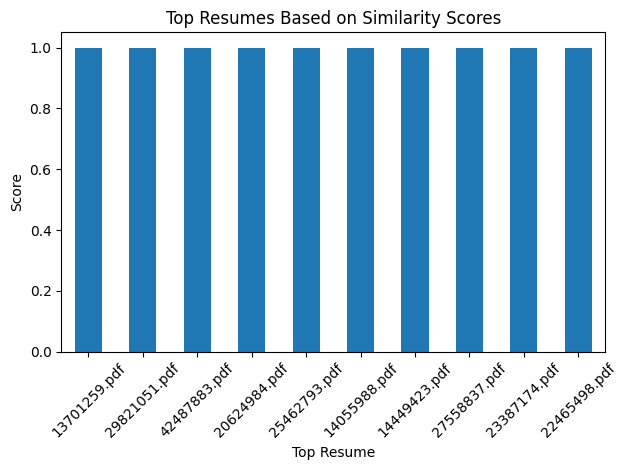

In [15]:
# Vẽ biểu đồ top resume
plt.figure(figsize=(10, 6))
results_df.sort_values(by='Score', ascending=False).head(10).plot(
    kind='bar', x='Top Resume', y='Score', legend=False
)
plt.title('Top Resumes Based on Similarity Scores')
plt.xlabel('Top Resume')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### 5. ĐÁNH GIÁ MÔ HÌNH

In [16]:
# Hàm thu thập phản hồi
def collect_feedback(resume, predicted_relevance):
    """Thu thập phản hồi từ người dùng."""
    print(f"Resume: {resume[:50]}...")
    print(f"Độ phù hợp dự đoán: {predicted_relevance}")
    feedback = input("Resume này có phù hợp không? (yes/no): ")
    return 1 if feedback.lower() == 'yes' else 0

In [17]:
# Hàm lưu phản hồi
def save_feedback(feedback):
    """Lưu phản hồi vào CSV."""
    feedback_df = pd.DataFrame([feedback])
    feedback_df.to_csv('D:/BaiDoAnChuyenNganh3/Automated-Resume-Ranking-System-main/csvfiles/feedback/feedback.csv', mode='a', header=False, index=False)

In [18]:
# Huấn luyện mô hình phân loại
def train_classification_model(resumes, labels):
    """Huấn luyện mô hình Random Forest để phân loại resume."""
    model = make_pipeline(TfidfVectorizer(), RandomForestClassifier())
    model.fit(resumes, labels)
    joblib.dump(model, 'D:/BaiDoAnChuyenNganh3/Automated-Resume-Ranking-System-main/Contacts/model/resume_ranking_model.pkl')
    print("Đã lưu mô hình vào 'resume_ranking_model.pkl'")
    return model

In [19]:
from sklearn.pipeline import make_pipeline

In [20]:
# Dữ liệu mẫu để huấn luyện
X_train = ["Resume text 1", "Resume text 2", "Resume text 3"]
y_train = [1, 0, 1]
model = train_classification_model(X_train, y_train)

Đã lưu mô hình vào 'resume_ranking_model.pkl'


In [21]:
# Dự đoán và thu thập phản hồi
new_resume = "This is a new resume text to check relevance."
predicted_relevance = model.predict([new_resume])[0]
print(f"Dự đoán độ phù hợp: {predicted_relevance}")
feedback_label = collect_feedback(new_resume, predicted_relevance)
save_feedback({'relevance': feedback_label, 'resume': new_resume})

Dự đoán độ phù hợp: 1
Resume: This is a new resume text to check relevance....
Độ phù hợp dự đoán: 1


In [22]:
# Cập nhật và huấn luyện lại mô hình
all_resumes = X_train + [new_resume]
all_labels = y_train + [feedback_label]
model = train_classification_model(all_resumes, all_labels)

Đã lưu mô hình vào 'resume_ranking_model.pkl'


In [23]:
# Đánh giá mô hình
X_test = ["Sample resume text 1", "Sample resume text 2"]
y_true = [1, 0]
y_pred = model.predict(X_test)
print(f"Độ chính xác: {accuracy_score(y_true, y_pred):.2f}")
print(f"Độ chính xác (Precision): {precision_score(y_true, y_pred):.2f}")
print(f"Độ bao quát (Recall): {recall_score(y_true, y_pred):.2f}")
print(f"F1 Score: {f1_score(y_true, y_pred):.2f}")

Độ chính xác: 0.50
Độ chính xác (Precision): 0.50
Độ bao quát (Recall): 1.00
F1 Score: 0.67


In [24]:
# Phân bố lớp
print("Phân bố lớp trong dữ liệu kiểm tra:")
print(pd.Series(y_true).value_counts())

Phân bố lớp trong dữ liệu kiểm tra:
1    1
0    1
Name: count, dtype: int64


### 6. GIAO DIỆN FLASK

In [ ]:
app = Flask(__name__)

@app.route('/')
def home():
    """Trang chủ với form nhập liệu."""
    return render_template('index.html')

@app.route('/predict', methods=['POST'])
def predict():
    """Dự đoán độ phù hợp của resume."""
    data = request.json
    new_resume = data['resume']
    predicted_relevance = model.predict([new_resume])[0]
    return jsonify({'relevance': int(predicted_relevance)})

@app.route('/submit', methods=['POST'])
def submit():
    """Xử lý phản hồi từ form."""
    return "Phản hồi đã được gửi!"

if __name__ == '__main__':
    app.run(debug=True)

 * Serving Flask app '__main__'
 * Debug mode: on


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit
 * Restarting with stat


SystemExit: 1

d:\BaiDoAnChuyenNganh3\.venv\Lib\site-packages\IPython\core\interactiveshell.py:3557: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)
